# Outline

- Step 1: Data Exploration
- Step 2: Review and Analyze Prompt
- Step 3: Start to create Analyses
- Step 4: Submit
- Step 5: Repeat 3-4 until optimized

Import packages and other shit

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datatable import dt, f

import files

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Step 1

In [3]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


I see text.

Use Natural Language Toolkit

What other problems are there? I don't know Thai.

How important is it to know Thai? Not really, there's a way to get around it, and that is using BERT

Also will need to import more packages which will be done below.

In [3]:
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf

We are going to explore the data.

What can we explore?
- Languages used
- Label distribution

Why explore these (respectively)?
- Curious as to languages used
- Check to see if data is imbalanced

Building off of that drill down on language and see which labels are part of the data
Why do this? It may throw off our analysis.

Languages used

<AxesSubplot:xlabel='language', ylabel='count'>

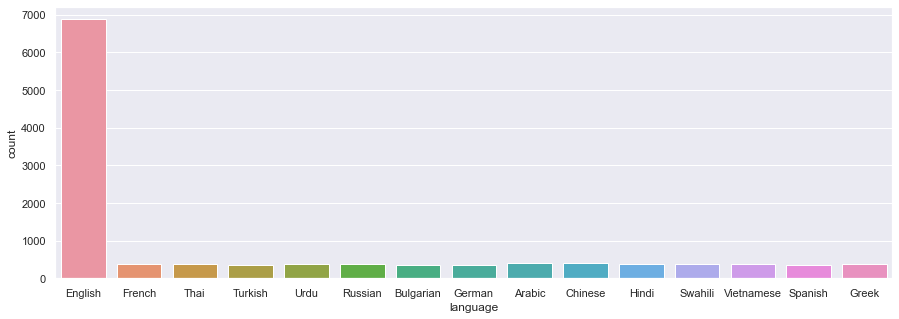

In [10]:
sns.set(rc={"figure.figsize":(15, 5)})
sns.countplot(x="language",data=train)

Label distribution

<AxesSubplot:xlabel='label', ylabel='count'>

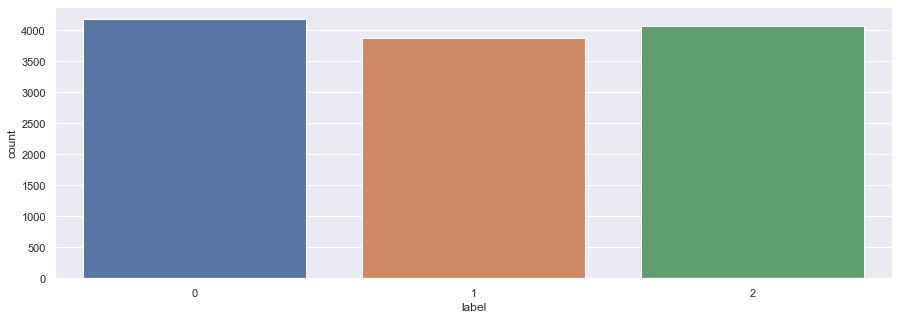

In [11]:
sns.countplot(x="label",data=train)

Languages aren't well distributed, the labels are let's look at how the labels are distributed based on language

create data frame to help with plotting

In [38]:
temp_df = pd.DataFrame(columns=["language","proportion","label"])
for i in train.language.unique():
    temp_dict = {}
    temp_dict["language"] = i
    for j in range(3):
        temp_dict["proportion"] = sum(train[train["language"]== i].label==j)/sum(train.language == i)
        temp_dict["label"] = j
        temp_df = temp_df.append(temp_dict,ignore_index=True)

C:\Users\Troy Stein\AppData\Local\Temp\ipykernel_14944\4236641402.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(temp_dict,ignore_index=True)
C:\Users\Troy Stein\AppData\Local\Temp\ipykernel_14944\4236641402.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(temp_dict,ignore_index=True)
C:\Users\Troy Stein\AppData\Local\Temp\ipykernel_14944\4236641402.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(temp_dict,ignore_index=True)
C:\Users\Troy Stein\AppData\Local\Temp\ipykernel_14944\4236641402.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = 

<AxesSubplot:xlabel='language', ylabel='proportion'>

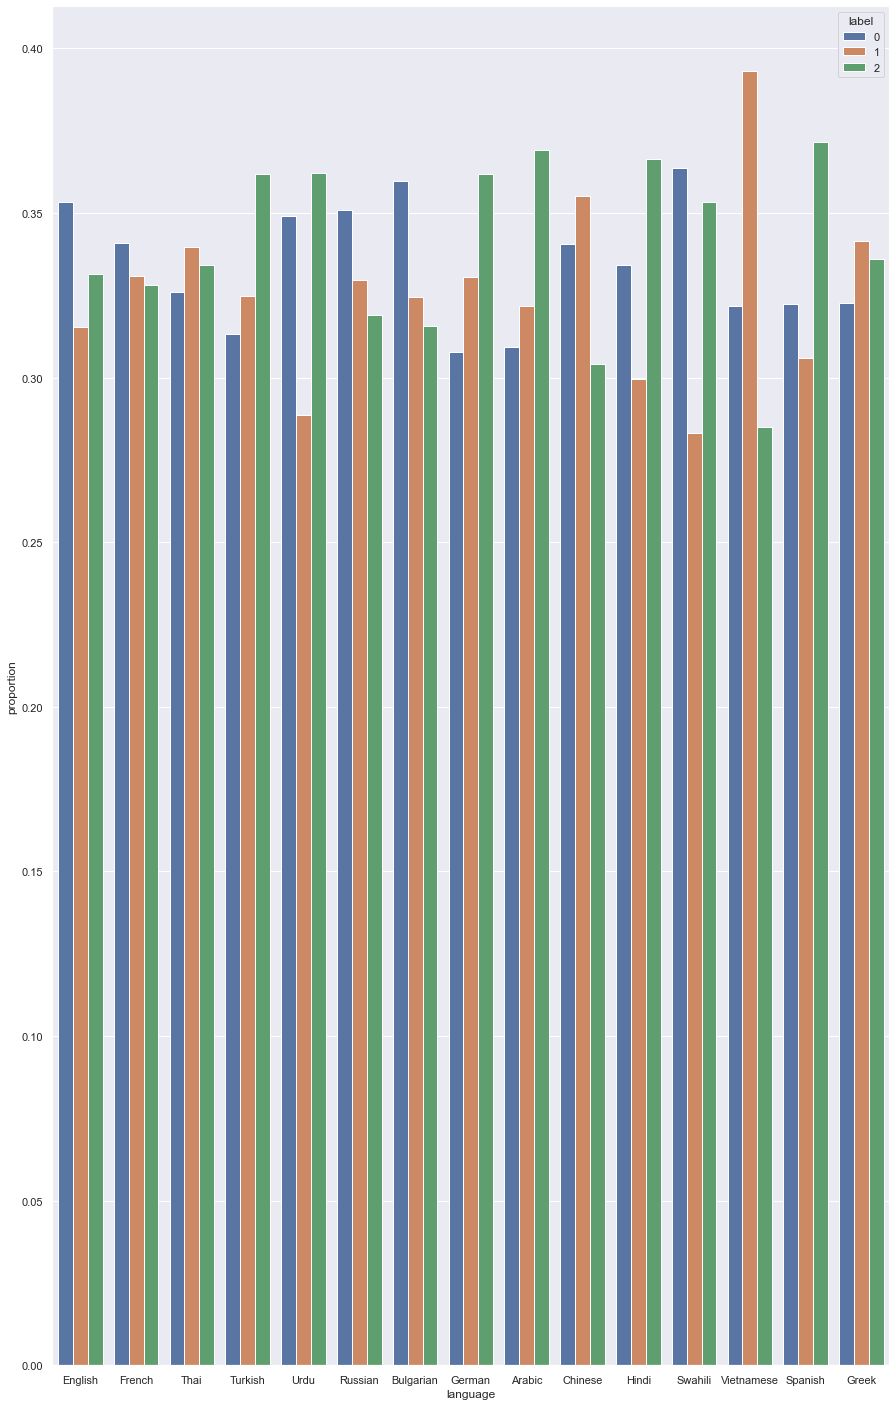

In [41]:
sns.set(rc={"figure.figsize":(15, 25)})
sns.barplot(x="language",y="proportion",hue="label",data=temp_df)

# Step 2

Goal: Identify how a pairing of sentences are related.

Here are the three categories (for prediction):

- Contradictory (negate each other)
- Entailment (make sense together)
- Unrelated (has nothing to do with the other)

Submission contains:

- id
- prediction

Remember to use Bert Tokenizer, and imbalance of languages.

Few questions does Bert tokenizer translate (i.e. Hola has same encoding as hello)?

Some languages will have off translations, how should we account for this? 

- Evaluate the language itself
- Look for key words
- Phrasing?

What can I do today?

- Start using BERT
- Do more research on BERT
- Continue research


Hey BERT let's use you

In [4]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading: 100%|██████████| 972k/972k [00:00<00:00, 4.90MB/s]
Downloading: 100%|██████████| 29.0/29.0 [00:00<00:00, 14.5kB/s]
Downloading: 100%|██████████| 625/625 [00:00<00:00, 209kB/s]


encoded sentence

In [5]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [6]:
encode_sentence("I love machine learning")

[146, 16138, 21432, 26901, 102]

In [14]:
encode_sentence("Hello Hola")

[31178, 20220, 10330, 102]

In [20]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


Ok, so answer is no it doesn't translate encodings such as Hello and Hola the same way. 
Bert encodign

In [15]:
def bert_encode(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [26]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [17]:
max_len = 50

def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [21]:
with strategy.scope():
    model = build_model()
    model.summary()

Downloading: 100%|██████████| 1.01G/1.01G [00:55<00:00, 19.4MB/s]
Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',         

c:\Users\Troy Stein\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
# @TODO: figure out how to run the tensorflow.
model.fit(train_input, train.label.values, epochs = 2, verbose = 1, batch_size = 64, validation_split = 0.2)

Epoch 1/2


ValueError: in user code:

    File "c:\Users\Troy Stein\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Troy Stein\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Troy Stein\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Troy Stein\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Troy Stein\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Troy Stein\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 50), found shape=(None, 259)


In [24]:
train.label.values.shape

(12120,)

In [25]:
train_input

{'input_word_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[  101, 10111, 11762, ...,     0,     0,     0],
        [  101, 13252, 10301, ...,     0,     0,     0],
        [  101, 13810, 32181, ...,     0,     0,     0],
        ...,
        [  101, 10117, 12452, ...,     0,     0,     0],
        [  101, 11699, 10105, ...,     0,     0,     0],
        [  101, 11399, 14764, ...,     0,     0,     0]])>,
 'input_mask': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])>,
 'input_type_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])>}